### Notebook preprocesses spatial tas data for observations and CMIP6 models to non-spatial 'global' and 'world without arctic' timeseries

The directory structure to the CMIP6 model data is proprietary to the JASMIN supercomputer, which has direct access to the CEDA archive. The code below will not find any model data if not run on JASMIN. 

Author: Alistair Duffey, alistair.duffey.21@ucl.ac.uk

In [22]:
import iris
import Utils.iris_utils as iris_utils
import pandas as pd
import numpy as np
import os
import logging
import esmvalcore.preprocessor
import glob
import warnings
warnings.filterwarnings("ignore")
from tqdm import tqdm
import xarray as xr
from xmip.preprocessing import rename_cmip6
import matplotlib.pyplot as plt

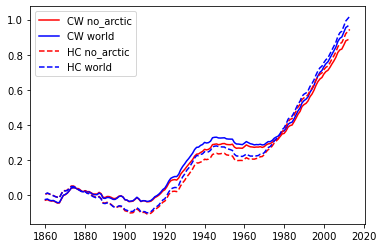

In [23]:
""" 
    preprocess observations from nc files to csvs of global and
    no_arctic global mean temp 
"""

def preprocess_obs(file, outpath, tas_string, arctic_cut_off=66):
    data = xr.open_mfdataset(file, use_cftime=True).load()
    data = data.groupby("time.year").mean(dim="time")
    data = data.mean("longitude")
    #print(data)
    new_lat = np.arange(-90, 90, 0.5)
    data = data.interp(latitude=new_lat)
    #print(data)
    
    years = data.year.compute()
                
    arctic_annual = data.sel(latitude=slice(-90,arctic_cut_off))
    world_w = data.weighted(weights=np.cos(np.deg2rad(data.latitude)))
    arctic_w = arctic_annual.weighted(weights=np.cos(np.deg2rad(arctic_annual.latitude)))
    
    
    df = pd.DataFrame({'no_arctic_tas':arctic_w.mean("latitude")[tas_string],
                        'world_tas':world_w.mean("latitude")[tas_string],
                        'year':years.values})
    
    df.set_index('year',inplace=True)
    df.sort_index(inplace=True)
    df.to_csv(outpath)

### run for hadcrut
out_file = 'int_outputs/temperature_hadcrut/hadcrut5_tas.csv'
Hadcrut_file = 'Inputs/HadCRUT5/Downloaded_29_12_22/HadCRUT.5.0.1.0.analysis.anomalies.ensemble_mean.nc'
preprocess_obs(Hadcrut_file, out_file, tas_string='tas_mean')

### run for C&W
out_file = 'int_outputs/temperature_CW/CW_tas.csv'
CW_file = 'Inputs/Cowtan_Way/had4_krig_v2_0_0.nc'
preprocess_obs(CW_file, out_file, tas_string='temperature_anomaly')

### test output of obs processing
def baseline_obs(df, window, preind_period=[1850,1900]):
    """ hadcrut analysis annual means tas data is donwloaded as anomaly relative to the period 
        1961-1990, (see description here: https://www.metoffice.gov.uk/hadobs/hadcrut5/data/current/download.html)
        we preprocess by re-baselining this to be anomaly relative to our preindustrial period, 1850-1900""
    
    returns df with tas relative to pre-industrial mean """
    #df.rename(columns={'Time':'Year'}, inplace=True)
    df_pre_ind = df[df['year'].between(preind_period[0], preind_period[1])]
    offset_w = df_pre_ind['world_tas'].mean()
    offset_na = df_pre_ind['no_arctic_tas'].mean()
    df_out = df.copy()
    df_out['world_tas'] = df_out['world_tas'] - offset_w
    df_out['no_arctic_tas'] = df_out['no_arctic_tas'] - offset_na
    df_out['world_tas'] = df_out['world_tas'].rolling(window, center=True).mean()
    df_out['no_arctic_tas'] = df_out['no_arctic_tas'].rolling(window, center=True).mean()
    return df_out

CW = baseline_obs(pd.read_csv('int_outputs/temperature_CW/CW_tas.csv'), 20)
HC = baseline_obs(pd.read_csv('int_outputs/temperature_hadcrut/hadcrut5_tas.csv'), 20)

plt.plot(CW['year'], CW['no_arctic_tas'], c='r', label='CW no_arctic')
plt.plot(CW['year'], CW['world_tas'], c='b', label='CW world')
plt.plot(HC['year'], HC['no_arctic_tas'], c='r', ls='--', label='HC no_arctic')
plt.plot(HC['year'], HC['world_tas'], c='b', ls='--', label='HC world')
plt.legend()

In [2]:
#exps = ["ssp370", "historical"]
exps = ["historical"]
#exps = ['ssp245']
#exps = ['ssp126']
dirs = []
var_path = "Amon/tas"
for experiment in exps:
    if experiment == "historical":
        exp_set = "CMIP"
    else:
        exp_set = "ScenarioMIP"
    for x in glob.glob('/badc/cmip6/data/CMIP6/{es}/*/*/{e}/*/{v}/*/latest/'.format(es=exp_set, e=experiment, v=var_path)):
        dirs.append(x)
dirs.reverse()
print(len(dirs))

394


In [3]:
def preprocess(folder, arctic_cut_off=66):
    
    """ makes a df contining global mean and {global except arctic} mean
        temp by year, for the first ensemble member of each model """
    
    outpath = 'int_outputs/temperature_v2/{M}_{Exp}.csv'.format(M=folder.split('/')[7], Exp=folder.split('/')[8])
    #outpath = 'int_outputs/temperature_v3/{M}_{Exp}_{Ens}.csv'.format(
    #                                    M=folder.split('/')[7], Exp=folder.split('/')[8], Ens=folder.split('/')[9])
    if os.path.exists(outpath):
        return
    else:                                                              
        try:
            data = rename_cmip6(xr.open_mfdataset(folder + "*.nc", use_cftime=True))
            winter_mask = data.time.dt.month.isin([12,1,2])
            jan_mask = data.time.dt.month.isin([1]) 
            name = str(folder.split('/')[7] + '_' + folder.split('/')[8] + '_' + folder.split('/')[9])
            
            at_data = data['tas']#.isel(member_id=0)
            
            #at_data = at_data[winter_mask]
            
            years = data.time.dt.year[jan_mask].compute()
            
            # month_length = data.time.dt.days_in_month
            # weights = ( month_length.groupby("time.season") / month_length.groupby("time.season").mean())
            world_annual = (at_data).groupby("time.year").mean(dim="time")
            arctic_annual = world_annual.sel(y=slice(-90,arctic_cut_off))
            
            world_w = world_annual.weighted(weights=np.cos(np.deg2rad(world_annual.y)))
            arctic_w = arctic_annual.weighted(weights=np.cos(np.deg2rad(arctic_annual.y)))
            
            df = pd.DataFrame({'no_arctic_tas':arctic_w.mean(("x","y")).compute().values,
                               'world_tas':world_w.mean(("x","y")).compute().values,
                               'year':years.values})
            
            df.set_index('year',inplace=True)
            df.sort_index(inplace=True)
            df['Model'] = folder.split('/')[7]
            df['Experiment'] = folder.split('/')[8]
            df['Ensemble_member'] = folder.split('/')[9]
            df.to_csv(outpath) 
        except:
            print(name)

for dir in tqdm(dirs):
    preprocess(dir)

In [40]:
def preprocess_multi_ens(folder, arctic_cut_off=66):
    
    """ makes a df contining global mean and {global except arctic} mean
        temp by year, for the first ensemble member of each model """
    
    outpath = 'int_outputs/temperature_multi_ens/{M}_{Exp}_{Ens}.csv'.format(
                M=folder.split('/')[7], Exp=folder.split('/')[8], Ens=folder.split('/')[9])
    
    if os.path.exists(outpath):
        return
    else:                                                              
        try:
            data = rename_cmip6(xr.open_mfdataset(folder + "*.nc", use_cftime=True))
            winter_mask = data.time.dt.month.isin([12,1,2])
            jan_mask = data.time.dt.month.isin([1]) 
            name = str(folder.split('/')[7] + '_' + folder.split('/')[8] + '_' + folder.split('/')[9])
            
            at_data = data['tas']#.isel(member_id=0)
            
            #at_data = at_data[winter_mask]
            
            years = data.time.dt.year[jan_mask].compute()
            
            # month_length = data.time.dt.days_in_month
            # weights = ( month_length.groupby("time.season") / month_length.groupby("time.season").mean())
            world_annual = (at_data).groupby("time.year").mean(dim="time")
            arctic_annual = world_annual.sel(y=slice(-90,arctic_cut_off))
            
            world_w = world_annual.weighted(weights=np.cos(np.deg2rad(world_annual.y)))
            arctic_w = arctic_annual.weighted(weights=np.cos(np.deg2rad(arctic_annual.y)))
            
            df = pd.DataFrame({'no_arctic_tas':arctic_w.mean(("x","y")).compute().values,
                               'world_tas':world_w.mean(("x","y")).compute().values,
                               'year':years.values})
            
            df.set_index('year',inplace=True)
            df.sort_index(inplace=True)
            df['Model'] = folder.split('/')[7]
            df['Experiment'] = folder.split('/')[8]
            df['Ensemble_member'] = folder.split('/')[9]
            df.to_csv(outpath) 
        except:
            print(name)

for dir in tqdm(dirs):
    preprocess_multi_ens(dir)